Goals:
- You should create a table with 3 columns: day, employee_headcount, company_id.
- What are the main factors that drive employee churn? Do they make sense? Explain your findings.
- If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('employee_retention.csv')

In [3]:
data.head()

employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22

In [4]:
len(data.employee_id.unique()) == len(data)

True

In order to get the table, we first create the numbe of people joining and quitting per day per company

In [5]:
data_join = data.groupby(by=['join_date', 'company_id'], as_index=False)['employee_id'].agg({'NumCon':'count'})
data_join.head()

join_date  company_id  NumCon
0  2011-01-24           1      25
1  2011-01-24           2      17
2  2011-01-24           3       9
3  2011-01-24           4      12
4  2011-01-24           5       5

In [6]:
data_quit = data.groupby(by=['quit_date', 'company_id'], as_index=False)['employee_id'].agg({'NumCon':'count'})
data_quit.head(10)

quit_date  company_id  NumCon
0  2011-10-13           6       1
1  2011-10-14          10       1
2  2011-10-21           1       1
3  2011-10-28           4       1
4  2011-11-11           1       1
5  2011-11-22           1       1
6  2011-11-25           1       1
7  2011-11-25           2       1
8  2011-12-02           6       1
9  2011-12-02           8       1

In [7]:
data_headcount = pd.merge(data_join, data_quit, how='left', left_on=['join_date', 'company_id'], right_on=['quit_date', 'company_id'])


In [8]:
data_headcount.loc[data_headcount.join_date == '2011-10-13', :]

join_date  company_id  NumCon_x quit_date  NumCon_y
748  2011-10-13           1         1       NaN       NaN
749  2011-10-13           2         1       NaN       NaN
750  2011-10-13           4         2       NaN       NaN
751  2011-10-13          12         1       NaN       NaN

In [9]:
data_headcount.NumCon_y = data_headcount.NumCon_y.fillna(0)
data_headcount.quit_date = data_headcount.quit_date.fillna(0)

In [10]:
data_headcount['diff'] = data_headcount.NumCon_x - data_headcount.NumCon_y

In [11]:
data_headcount.head()

join_date  company_id  NumCon_x quit_date  NumCon_y  diff
0  2011-01-24           1        25         0       0.0  25.0
1  2011-01-24           2        17         0       0.0  17.0
2  2011-01-24           3         9         0       0.0   9.0
3  2011-01-24           4        12         0       0.0  12.0
4  2011-01-24           5         5         0       0.0   5.0

In [12]:
result1 = data_headcount[['join_date', ]]

In [13]:
result1.head()

join_date
0  2011-01-24
1  2011-01-24
2  2011-01-24
3  2011-01-24
4  2011-01-24

---------------------------------------------
Then we analyze the churn. Let's first calculate the employment length.

In [14]:
data.head()

employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22

In [15]:
data.join_date = pd.to_datetime(data.join_date, format='%Y-%m-%d')
data.quit_date = pd.to_datetime(data.quit_date, format='%Y-%m-%d')


In [16]:
data.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date  
0 2015-10-30  
1 2014-04-04  
2        NaT  
3 2013-06-07  
4 2014-08-22

In [17]:
data['emp_length'] = pd.Series(data.quit_date - data.join_date).map(lambda x: x.days)

In [18]:
data.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date  emp_length  
0 2015-10-30       585.0  
1 2014-04-04       340.0  
2        NaT         NaN  
3 2013-06-07       389.0  
4 2014-08-22      1040.0

there are peaks around each employee year anniversary!

/Users/pinecone/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/pinecone/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


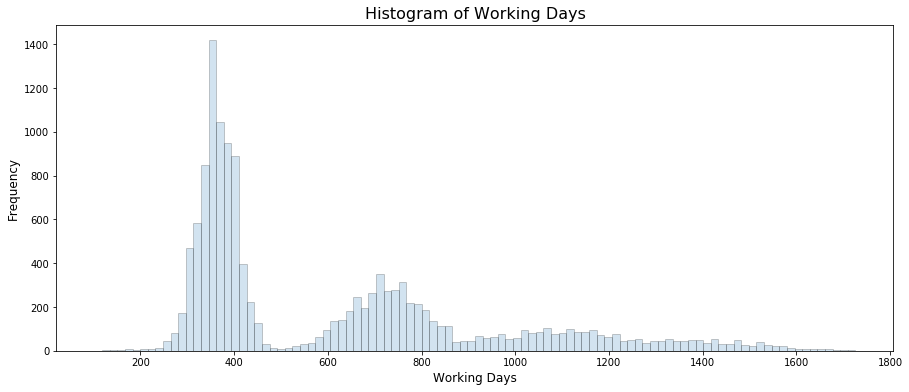

In [19]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(data.emp_length, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [20]:
data['quit_month'] = data.quit_date.dt.month
data['quit_week'] = data.quit_date.dt.week

In [21]:
data.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date  emp_length  quit_month  quit_week  
0 2015-10-30       585.0        10.0       44.0  
1 2014-04-04       340.0         4.0       14.0  
2        NaT         NaN         NaN        NaN  
3 2013-06-07       389.0         6.0       23.0  
4 2014-08-22      1040.0         8.0       34.0

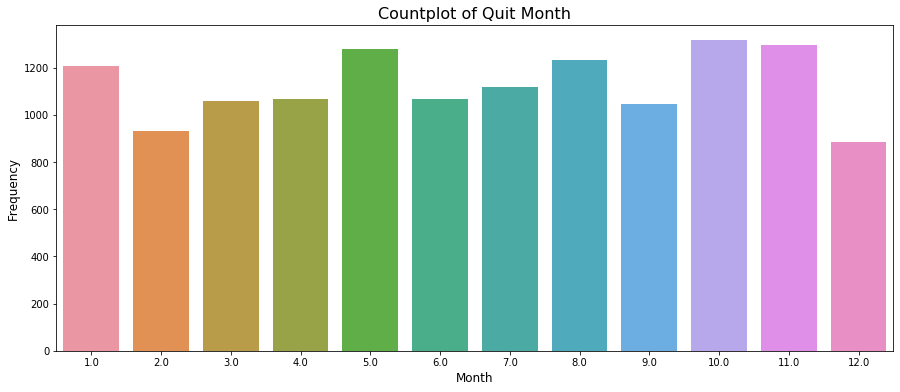

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data.quit_month, ax=ax)
ax.set_title('Countplot of Quit Month', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

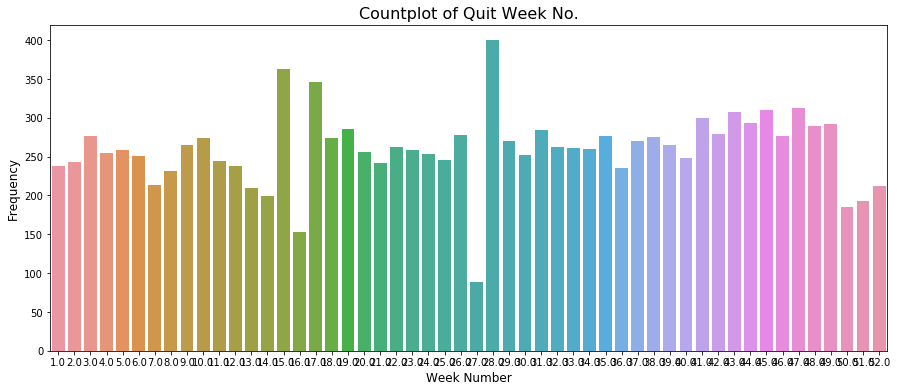

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data.quit_week, ax=ax)
ax.set_title('Countplot of Quit Week No.', fontsize=16)
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

Build model

In [37]:
data =data.dropna()
y = [1 if elem <= 396 else 0 for elem in data.emp_length]
data['res'] = y

In [38]:
data.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   
5     509529.0           4      data_science         14  165000.0 2012-01-30   

   quit_date  emp_length  quit_month  quit_week  res  
0 2015-10-30       585.0        10.0       44.0    0  
1 2014-04-04       340.0         4.0       14.0    1  
3 2013-06-07       389.0         6.0       23.0    1  
4 2014-08-22      1040.0         8.0       34.0    0  
5 2013-08-30       578.0         8.0       35.0    0

In [39]:
X = data.iloc[:, [1, 2, 3, 4]]

In [40]:
X.head()

company_id              dept  seniority    salary
0           7  customer_service         28   89000.0
1           7         marketing         20  183000.0
3           7  customer_service         20  115000.0
4           2      data_science         23  276000.0
5           4      data_science         14  165000.0

In [41]:
for col in X.columns[0:2]:
    lb = LabelEncoder()
    X[col] = lb.fit_transform(X[col].tolist())

/Users/pinecone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [43]:
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      7541
           1       0.00      0.00      0.00      5969

    accuracy                           0.56     13510
   macro avg       0.28      0.50      0.36     13510
weighted avg       0.31      0.56      0.40     13510



/Users/pinecone/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
clf.feature_importances_

array([0., 0., 0., 1.])

In [45]:
clf.max_leaf_nodes

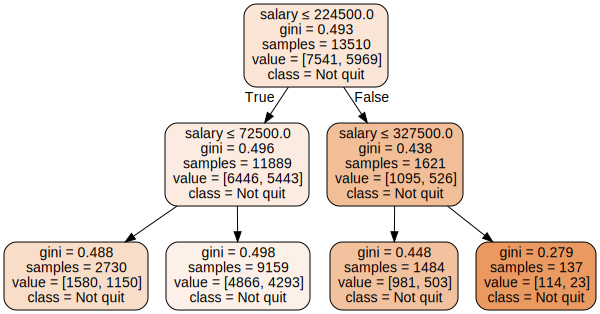

In [46]:

features = list(X.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
graph

We can see that salary is the most important feature.

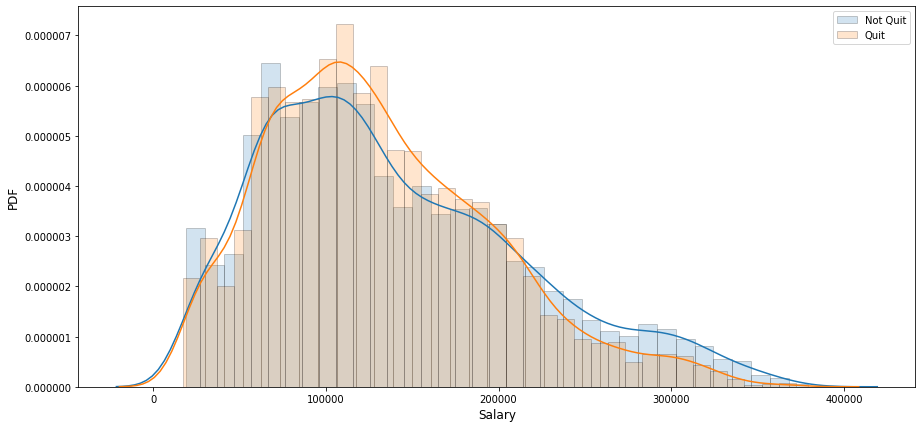

In [47]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(data.loc[data.res == 0,'salary'], 
             label='Not Quit', ax=ax, hist_kws=hist_kws)
sns.distplot(data.loc[data.res == 1,'salary'], 
             label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

## Other Factors

Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.